# <b>Data Exploration</b>
In this notebook we use mediapipe to detect poses of the signers. The results are set of points for every frame for every video.

In [2]:
import pandas as pd
import os
import json
import numpy as np
import cv2
import pickle


In [3]:
working_dir = './'
data_info = pd.read_csv(os.path.join(working_dir,'video_labels.csv'),dtype={'video_id': object})
data_info.head(2)

,bbox,fps_x,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,word,fps_y,width,height,duration
0,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,book,29.970030,1280,720,2.50250
1,"[462, 44, 949, 720]",25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,07069,book,23.976024,1280,720,1.25125


In [4]:
def get_landmarks(results):
  landmarks = {}
  landmarks['pose'] = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros(33*4)
  landmarks['face'] = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]) if results.face_landmarks else np.zeros(468*3)
  landmarks['lh'] = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros(21*3)
  landmarks['rh'] = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros(21*3)
  return landmarks

In [13]:
# Progress bar
import sys

def progres_bar(i,total):
        sys.stdout.write('\r')
        # the exact output you're looking for:
        sys.stdout.write(f"[%-{50}s] %d%%" % ('#'*int(i/(total/50)), (100/total)*i))
        sys.stdout.flush()

In [5]:
# Load landmarks from the pickle file
landmarks = None
try:
    with open(os.path.join(working_dir,'landmarks.pkl'), 'rb') as file:
        landmarks = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, initialize the variable
    print('Could not open landmarks.pkl')
    landmarks = {} # This value contains the landmarks points of all frames, in all the videos
print(len(landmarks.keys()),'out of',len(data_info))

4081 out of 11980


In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
batch = 200
i = 0 # For manually processing in batches in case Colab won't allow long execution
for inx in data_info.loc[data_info.split=='train'].index:
  video_id = data_info.loc[inx,'video_id']
  if video_id in landmarks:
    continue
  video_file = os.path.join(working_dir,'videos',video_id +'.mp4')
  cap = cv2.VideoCapture(video_file)
  # Set mediapipe model
  ret, frame = cap.read()
  video_landmarks  = np.array([])
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
      while True:
          # Read feed
          ret, frame = cap.read()
          if not ret:
            break
          x, y, h, w = json.loads(data_info.loc[inx,'bbox'])
          bounded_frame = frame[y:y+h, x:x+w]
          # Make detections
          results = holistic.process(bounded_frame)  # Finds pose
          # save the landmarks for that frame
          frame = get_landmarks(results)
          video_landmarks = np.append(video_landmarks,frame)
  cap.release()
  landmarks[video_id] = video_landmarks
  i+=1
  progres_bar(i,batch)
  if i >= batch:
    break
  cap.release()



[##################################################] 100%

In [12]:
# Save landmarks to a pickle file
with open(os.path.join(working_dir,'landmarks.pkl'), 'wb') as file:
    pickle.dump(landmarks, file)

## Data Augmentation

In the subsequent analysis, we shift our focus from the raw images to the associated landmarks. While it's plausible to encounter slight variations in pose estimations from the Mediapipe library, we proceed with the assumption that these differences are negligible. Consequently, we treat the extracted landmarks as constant for our further analyses.

### Augmented data typea
One way we augment the data is by moving the landmarks around, not linearly as a group (meaning not by shifting the whole frame to some direction), but rather as subgroup, more specifically, the hands. Different people will wave their hands in different distances from their face, so we can move the hands slighlt lower, higher, sideways in respect to the face.

What we don't want to do is to randomly add a small $\sigma_x,\sigma_y$ to each point, this cause the distortion of the picture and make it unrealistic for a human body.

Other type of augmented data are flipped pictures, we take the $x$ coordinate of the center of the face as reflection axis.

Third type of augmented data are zoomed pictures, we take the center of the frame as given in the bounding box ( given in a columnm, for each video) and push (or pull) al the points away from it.

Lastly, we have an idea that we should test, removing random landmarks points, this data might come in reality when mediapipe fails to find all the points.

In [6]:
# For demonstration purposes we work with a small fraction of the data, say 20 videos
video_ids = list(landmarks.keys())[:20]
landmarks = {key: landmarks[key] for key in video_ids}

#for video_id, pose in landmarks:
    # Do something

In [7]:
key, pose = list(landmarks.items())[19]
pose = pose[20] # one frame for now

In [171]:
for key in pose:
    np.savetxt(key+'.txt',pose[key])

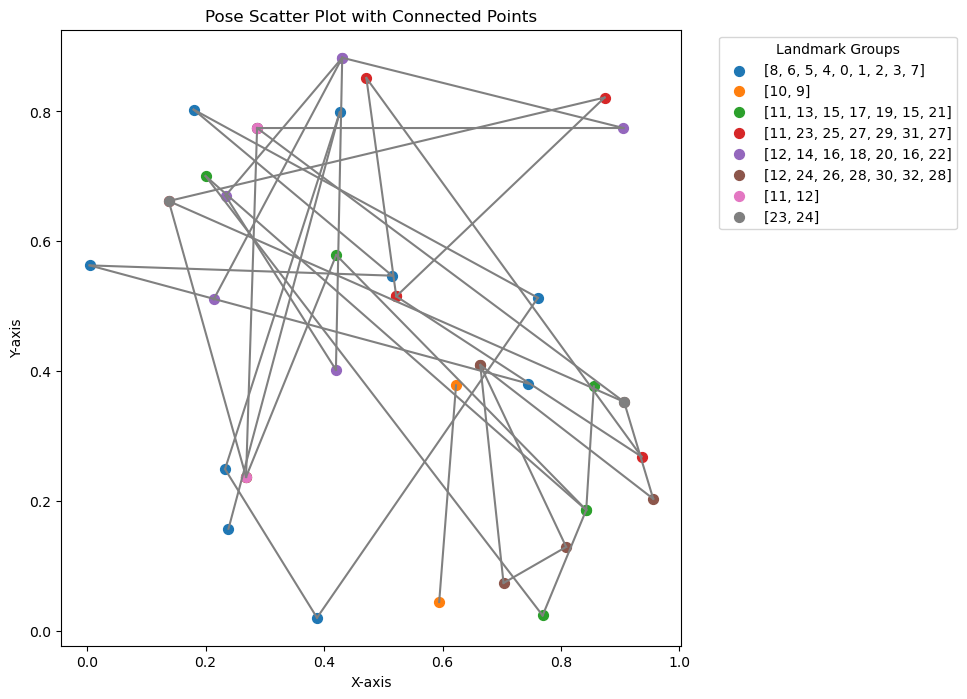

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example coordinates for the pose, replace this with your actual data
pose = np.random.rand(33, 2)  # Replace with your actual pose coordinates

LANDMARK_GROUPS = [
    [8, 6, 5, 4, 0, 1, 2, 3, 7],   # eyes
    [10, 9],                       # mouth
    [11, 13, 15, 17, 19, 15, 21],  # right arm
    [11, 23, 25, 27, 29, 31, 27],  # right body side
    [12, 14, 16, 18, 20, 16, 22],  # left arm
    [12, 24, 26, 28, 30, 32, 28],  # left body side
    [11, 12],                      # shoulder
    [23, 24],                      # waist
]

# Scatter plot
plt.figure(figsize=(8, 8))

for group in LANDMARK_GROUPS:
    group_coordinates = pose[group]
    plt.scatter(group_coordinates[:, 0], group_coordinates[:, 1], label=str(group), s=50)

    # Connect the points in the group
    for i in range(len(group) - 1):
        plt.plot(group_coordinates[i:i+2, 0], group_coordinates[i:i+2, 1], color='gray')

# Add labels and legend
plt.title("Pose Scatter Plot with Connected Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend(title="Landmark Groups", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


<Axes: >

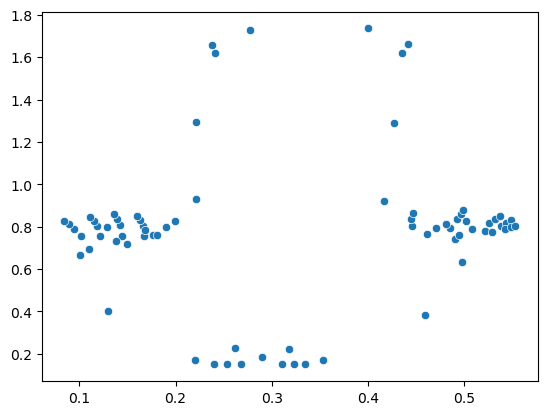

In [8]:
import seaborn as sns
pose_type = lambda x: [[p[0],p[1]] for p in pose[x]] 
pose_data = np.array(pose_type('lh')+
                     pose_type('rh')+
                     pose_type('pose'))
#                     pose_type('face'))
sns.scatterplot(x=pose_data[:,0], y=pose_data[:,1])
